# Conditional generative transformer: MNIST demo

Based off https://github.com/GregorKobsik/ImageTransformer

- mnist dataset
    - quantize to 8 values
    - random masking
- model
    - attention mask so that each pixel doesn't get itself as input?
    - predict output distribution for particular pixel
- training
    - learning rate schedule

In [1]:
model_name = input()
print()
new_kernel = True

use_wandb = True
if use_wandb:
    import wandb
    wandb_id = wandb.util.generate_id()

 shuffle


In [2]:
config = {
    'learning_rate': 0.001,
    'batch_size': 16,
    'n_colors': 8,
    'model': {
        'n_layers': 8,
        'ffl_dim': 256,
        'embd_dim': 64,
        'n_heads': 4,
        'dropout_rate': 0.1,
    },
    'dataset': {
        'buffer_size': 10000,
        'min_mask': 100,
        'max_mask': 740,
        'square_regions': False,
    },
    'lr_warmup_steps': 2000,
    'steps_per_epoch': 1000,
    'n_epochs': 10,
    'seq_length': 784,
}

In [3]:
if use_wandb:
    resume = not new_kernel
    wandb.init(project='cgt-mnist', entity='maxeonyx', name=model_name + '-' + wandb_id, config=config, resume=resume)

wandb: Currently logged in as: maxeonyx (use `wandb login --relogin` to force relogin)
/am/monterey/home1/clarkemaxw/.cache/pypoetry/virtualenvs/msc-4QRxScII-py3.8/lib/python3.8/site-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "
wandb: wandb version 0.12.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
import tensorflow as tf
# https://stackoverflow.com/a/60699372/7989988
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
import numpy as np
from tensorflow import keras
from tensorflow.keras import Model, Input, layers
from IPython.display import display
import tensorflow_datasets as tfds
import time
import matplotlib.pyplot as plt
import enlighten

2021-10-20 15:20:35.471728: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-20 15:20:35.957988: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10421 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:3b:00.0, compute capability: 6.1
2021-10-20 15:20:36.026247: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-20 15:20:36.062404: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached 

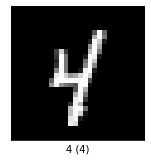

2021-10-20 15:20:36.140707: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


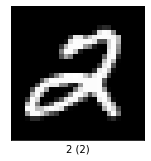

In [5]:
dataset, metadata = tfds.load('mnist', with_info=True, as_supervised=True)

dataset_train_original = dataset['train']
dataset_test_original = dataset['test']

image_width=28
image_height=28

fig = tfds.show_examples(dataset_train_original.take(1), metadata)
fig = tfds.show_examples(dataset_test_original.take(1), metadata)

In [6]:
from sklearn.cluster import MiniBatchKMeans

def normalize_image(image, label):
    return tf.cast(image, dtype=tf.float16) / 255.0, label

def find_centroids(ds_train, num_clusters, batch_size):
    kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=0, batch_size=batch_size, verbose=True)
    ds_batched = ds_train.batch(batch_size)
    with enlighten.get_manager() as manager:
        title = manager.status_bar(f"K-Means clustering to make {num_clusters}-color MNIST Dataset", justify=enlighten.Justify.CENTER)
        clusters_names = manager.status_bar(''.join('{:<10}'.format(f"cen. {i}") for i in range(num_clusters)))
        clusters_status = manager.status_bar(''.join('{:<10}'.format('??????') for _ in range(num_clusters)))
        pbar = manager.counter(total=60000//batch_size, desc='Discretize to 8 colors', unit='minibatches')
        for img, _ in pbar(iter(ds_batched)):
            pixels = img.numpy().reshape(-1, 1)
            kmeans.partial_fit(pixels)
            clusters_status.update(''.join('{:<10.3f}'.format(x[0]) for x in np.sort(kmeans.cluster_centers_, axis=0)))

        return kmeans.cluster_centers_

centroids = find_centroids(dataset_train_original.map(normalize_image), num_clusters=config['n_colors'], batch_size=1000)
centroids = tf.convert_to_tensor(np.sort(centroids, axis=0), dtype=tf.float16)
print(centroids.shape)

(8, 1)


In [7]:
def squared_euclidean_distance(a, b):
    b = tf.transpose(b)        
    a2 = tf.math.reduce_sum(tf.math.square(a), axis=1, keepdims=True)
    b2 = tf.math.reduce_sum(tf.math.square(b), axis=0, keepdims=True)
    ab = tf.linalg.matmul(a, b)
    return a2 - 2 * ab + b2

def flatten(image, label):
    shape = tf.shape(image) # (height, width, color)
    sequence = tf.reshape(image, (-1, shape[2])) # (height * width, color)
    return sequence, label

def quantize(sequence, label):
    d = squared_euclidean_distance(sequence, centroids) # (height * width, centroids)
    sequence = tf.math.argmin(d, axis=1)  # (height * width)
    return sequence, label

def unquantize(x):
    x_one_hot = tf.cast(tf.one_hot(x, depth=len(centroids)), dtype=tf.float16)  # (seq, num_centroids)
    return tf.linalg.matmul(x_one_hot,centroids)  # (seq, num_features)

def shuffled_indices(sequence, label):
    
    idxs = tf.range(config['seq_length'], dtype=tf.int32)
    idxs = tf.random.shuffle(idxs)
    
    sequence = tf.gather(sequence, idxs)
    
    return sequence, idxs, label

def indices(sequence, label):
    
    idxs = tf.range(config['seq_length'], dtype=tf.int32)
    
    return sequence, idxs, label

dataset_train = (
    dataset_train_original
    .map(normalize_image)
    .map(flatten)
    .map(quantize)
    .map(shuffled_indices)
    .cache()
    .repeat()
    .shuffle(config['dataset']['buffer_size'])
    .batch(config['batch_size'], drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)
dataset_test = (
    dataset_test_original
    .map(normalize_image)
    .map(flatten)
    .map(quantize)
    .map(indices)
    .cache()
    .batch(config['batch_size'], drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

unquantized:


2021-10-20 15:20:53.066896: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


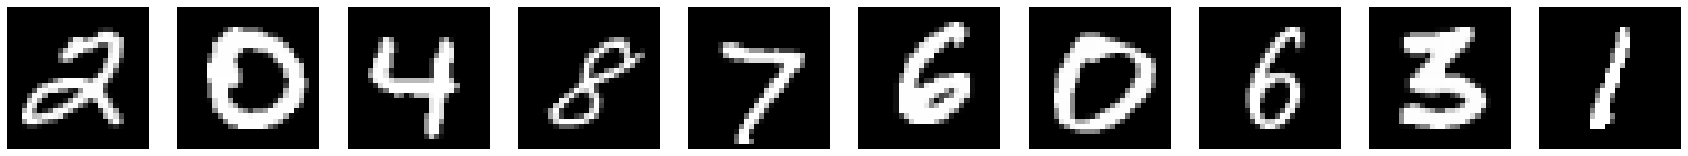

quantized:


2021-10-20 15:20:53.592417: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


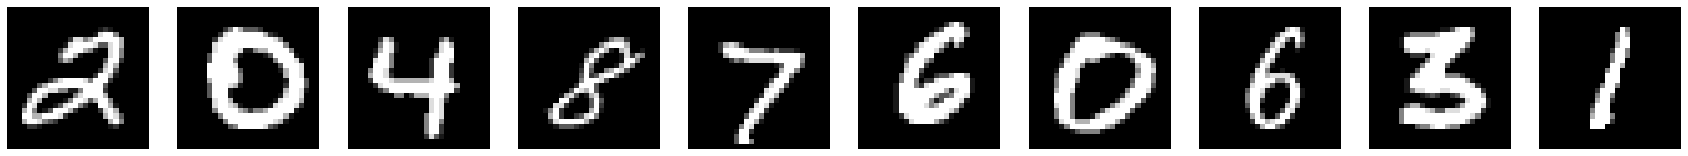

In [8]:
def np_showSeq(seq, size, max_images=3, cmap=None):
    """ Show one or more images encoded as sequence. (numpy version)

        seq: numpy array of sequences which encode the image. Either a single sequence or multiple sequences.
        size: the image size. e.g. (28, 28) for `mnist` images.
        max_images: the maximum number of images to display.
    """ 
    batch = seq.shape[0]
    num_show_img = min(max_images, seq.shape[0])
    img = np.reshape(seq, (batch, *size, -1))
    if img.shape[-1] == 1:
        img = np.squeeze(img, axis=-1)    
    
    fig=plt.figure(figsize=(3*num_show_img, 3))
    for i in range(num_show_img):
        ax = fig.add_subplot(1, num_show_img, i+1)
        ax.set_axis_off()
        plt.imshow(img[i], cmap=cmap)
    plt.show()

def showSeq(seq, size, max_images=3, cmap='gray', do_unquantize=True):
    """ Show one or more images encoded as sequence. (tensorflow version)

        seq: tensor of sequences which encode the image. Either a single sequence or multiple sequences.
        size: the image size. e.g. (28, 28) for `mnist` images.
        max_images: the maximum number of images to display.
    """
    if do_unquantize:
        seq = tf.map_fn(fn=unquantize, elems=seq, fn_output_signature=tf.float16)
    seq = tf.cast(seq, float).numpy()

    np_showSeq(seq, size, max_images, cmap)
    
NUM_SAMPLES = 10

ds_test_unquantized = (
    dataset_test_original
    .map(normalize_image)
    .map(flatten)
    .batch(NUM_SAMPLES)
)
ds_test_quantized = (
    dataset_test_original
    .map(normalize_image)
    .map(flatten)
    .map(quantize)
    .batch(NUM_SAMPLES)
)
print("unquantized:")
examples_unquantized, _ = next(iter(ds_test_unquantized))
showSeq(examples_unquantized, (image_width, image_height), NUM_SAMPLES, do_unquantize=False)
print("quantized:")
examples_quantized, _ = next(iter(ds_test_quantized))
showSeq(examples_quantized, (image_width, image_height), NUM_SAMPLES)

In [16]:
def create_look_ahead_mask(size_q, size_k):
    mask = 1 - tf.linalg.band_part(tf.ones((size_q, size_k)), -1, 0)
    return mask  # (seq_len, seq_len)

def scaled_dot_product_attention(k, q, v, mask):
    batch_size = tf.shape(k)[0]
    seq_len_kv = tf.shape(k)[-2]
    kq_dim = tf.shape(k)[-1]
    seq_len_q = tf.shape(q)[-2]
    v_dim = tf.shape(v)[-1]
    
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    # shape: (batch_size, n_heads, seq_len_q, seq_len_kv)
    
    dk = tf.cast(kq_dim, tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    if mask is not None:
        mask = create_look_ahead_mask(seq_len_q, seq_len_kv)
        scaled_attention_logits += mask * -1e9 # batch dim broadcast
    
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) # sums to 1 along last axis
    # shape: (batch_size, seq_len_q, seq_len_kv)
    
    output = tf.matmul(attention_weights, v)
    # shape: (batch_size, seq_len_q, v_dim)
    
    return output, attention_weights

def multi_head_attention(embd_dim, n_heads):
    
    wk = layers.Dense(embd_dim)
    wq = layers.Dense(embd_dim)
    wv = layers.Dense(embd_dim)
    dense = layers.Dense(embd_dim)
    
    assert embd_dim % n_heads == 0, "embd_dim must divide evenly into n_heads"
    head_width = embd_dim//n_heads
    
    def split_heads(x, batch_size):
        # reshape from (batch_size, seq_length, embd_dim) to (batch_size, num_heads, seq_len, head_width)
        x = tf.reshape(x, (batch_size, -1, n_heads, head_width))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(k, q, v, mask):
        batch_size = tf.shape(k)[0]
        
        k = wk(k)
        q = wk(q)
        v = wk(v)
        # shape: (batch_size, seq_len_*, embd_dim)
        
        k = split_heads(k, batch_size)
        q = split_heads(q, batch_size)
        v = split_heads(v, batch_size)
        # shape: (batch_size, num_heads, seq_len_*, head_width)
        
        scaled_attention, attention_weights = scaled_dot_product_attention(k, q, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        # (batch_size, seq_len, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, embd_dim))
        output = dense(concat_attention)
        return output, attention_weights
    return call
    
def pointwise_feedforward_layer(hidden_dim, out_dim):
    dense1 = layers.Dense(hidden_dim, activation='relu')
    dense2 = layers.Dense(out_dim)
    def call(x):
        x = dense1(x)
        x = dense2(x)
        return x
    return call
        

def transformer(n_colors, seq_length, mask, embd_dim, ffl_dim, n_heads, n_layers, dropout_rate):
    print("n_colors, seq_length, mask, embd_dim, ffl_dim, n_heads, n_layers, dropout_rate")
    print(n_colors, seq_length, mask, embd_dim, ffl_dim, n_heads, n_layers, dropout_rate)
    def decoder_layer():
        mha = multi_head_attention(embd_dim, n_heads)
        ffl = pointwise_feedforward_layer(ffl_dim, embd_dim)
        layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        dropout1 = layers.Dropout(dropout_rate)
        dropout2 = layers.Dropout(dropout_rate)
        def call(x, mask):
            out1 = layernorm1(dropout1(x))
            attn_out, attn_weights = mha(out1, out1, out1, mask)
            x += attn_out
            
            out2 = layernorm2(dropout2(x))
            ffl_out = ffl(out2)
            x += ffl_out
            
            return x
        return call

    def decoder_block():
        color_embedding = layers.Embedding(n_colors, embd_dim)
        position_embedding = layers.Embedding(seq_length, embd_dim)
        dec_layers = [decoder_layer() for _ in range(n_layers)]
        dropout = layers.Dropout(dropout_rate)
        layer_norm = layers.LayerNormalization(epsilon=1e-6)
        def call(colors, idxs, mask):
            batch = tf.shape(colors)[0]
            seq_len = tf.shape(colors)[1]
            
            col_embd = color_embedding(colors)
            pos_embd = tf.tile(position_embedding(idxs), [batch, 1, 1])
            x = col_embd + pos_embd
            for i in range(n_layers):
                x = dec_layers[i](x, mask)
            x = layer_norm(dropout(x))
            return x
        return call
    
    colors = keras.Input([seq_length])    
    idxs = keras.Input([seq_length])
    x = decoder_block()(colors, idxs, mask)
    final_layer = layers.Dense(n_colors)(x)
    
    return Model(inputs=[colors, idxs], outputs=[final_layer])



In [17]:

model = transformer(
    config['n_colors'],
    config['seq_length'],
    mask=True,
    **config['model'],
)

from keras.utils.vis_utils import plot_model

# plot_model(model, to_file="model.png", expand_nested=True, show_shapes=True, show_layer_names=True)


n_colors, seq_length, mask, embd_dim, ffl_dim, n_heads, n_layers, dropout_rate
8 784 True 64 256 4 8 0.1


2021-10-20 15:51:21.174045: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2021-10-20 15:51:21.175013: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


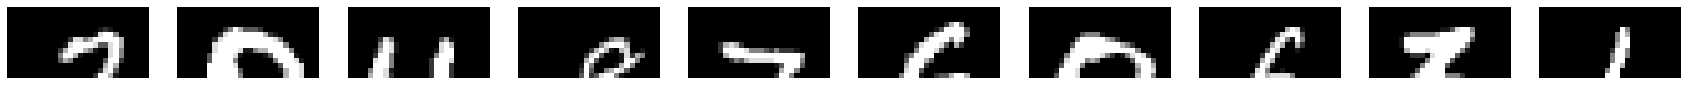

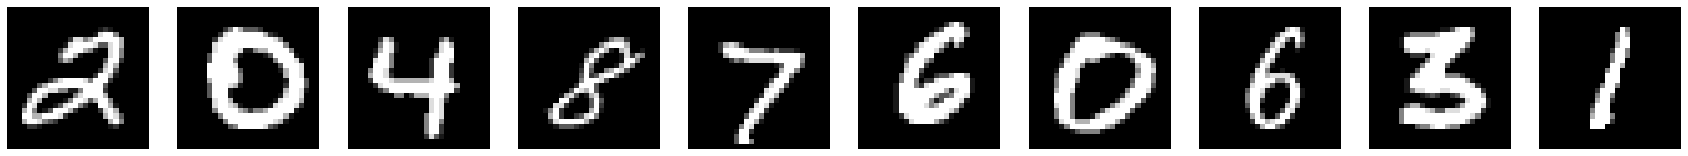

2021-10-20 15:51:22.077868: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


ValueError: in user code:

    /tmp/ipykernel_1625192/1729363644.py:30 train_step  *
        x_out = model(x_inp, i_inp)
    /am/monterey/home1/clarkemaxw/.cache/pypoetry/virtualenvs/msc-4QRxScII-py3.8/lib/python3.8/site-packages/keras/engine/base_layer.py:1020 __call__  **
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /am/monterey/home1/clarkemaxw/.cache/pypoetry/virtualenvs/msc-4QRxScII-py3.8/lib/python3.8/site-packages/keras/engine/input_spec.py:199 assert_input_compatibility
        raise ValueError('Layer ' + layer_name + ' expects ' +

    ValueError: Layer model_1 expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'strided_slice:0' shape=(None, None) dtype=int64>]


In [20]:
class TransformerLearningRateSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, embd_dim, warmup_steps):
        super(TransformerLearningRateSchedule, self).__init__()

        self.d_model = embd_dim
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

lr_schedule = TransformerLearningRateSchedule(config['model']['embd_dim'], config['lr_warmup_steps'])
# params taken from the linked notebook
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.95, epsilon=1e-9)
loss_function = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='sum_over_batch_size')
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None), dtype=tf.int64),
]
@tf.function(input_signature=train_step_signature)
def train_step(colors, idxs):
    x_inp = colors[:, :-1]
    x_tar = colors[:, 1:]
    i_inp = idxs[:, :-1]
    with tf.GradientTape() as tape:
        x_out = model(x_inp, i_inp)
        loss = loss_function(x_tar, x_out)
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

eval_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]
@tf.function(input_signature=eval_step_signature)
def eval_step(inp):
    return model(inp, training=False)

def evaluate(inp_colors, inp_idxs, manager=None):
    
    out_colors = inp_colors

    # create target and transform to batched shape
    target = tf.expand_dims(tf.cast([0], dtype=tf.int64), axis=0)
    target = tf.tile(target, [seq.shape[0], 1])
    if manager is None:
        manager = enlighten.get_manager()
    evaluate_counter = manager.counter(total=idx, desc="Evaluating", unit='pixels', leave=False)
    for _ in evaluate_counter(range(seq_length)):
        logits = eval_step(out_colors, inp_idxs)
        # apply softmax on the logits and return the result
        predictions = tf.random.categorical(logits[:, -1], 1, dtype=tf.int64)
        # append prediction
        out_colors = tf.concat([out_colors, predictions], axis=-1)
    evaluate_counter.close()
    return out_colors

def process_batch(inp_colors, inp_idxs, show_input=True, show_output=True, manager=None):
    batch_size = inp_colors.shape[0]
    n = int(inp_colors.shape[-1] / 2) 
    half_colors = inp_colors[:, :n]
    half_idxs = inp_idxs[:, :n]
    if show_input:
        showSeq(half_colors, (image_width//2, image_height), batch_size)
        showSeq(inp_colors, (image_width, image_height), batch_size)
    if show_output:
        result_seq = evaluate(inp_sequence, manager=manager)
        showSeq(result_seq, (image_width, image_height), batch_size)

batch_colors, batch_idxs, batch_labels = next(iter(dataset_test))
process_batch(batch_colors[0:10], batch_idxs[0:10], show_output=False)

n_epochs = config['n_epochs']
steps_per_epoch = config['steps_per_epoch']
loss_history = np.zeros([n_epochs*steps_per_epoch])
window_size = 10

dataset_iterator = iter(dataset_train)

with enlighten.get_manager() as manager:
    status = manager.status_bar(f"Training model '{model_name}'", justify=enlighten.Justify.CENTER)
    info = manager.status_bar('Loss: ??????, Learning Rate: ???????')
    def update_infobar(loss, learning_rate):
        info.update(f'Loss (10 step avg.): {loss:.5f}, Learning Rate: {learning_rate:.6f}')
    epochs = manager.counter(total=n_epochs, desc='Epochs', color='green', unit='epochs')
    last_loss = None
    last_step = 0
    for epoch in epochs(range(n_epochs)):
        steps = manager.counter(total=steps_per_epoch, desc=f'Epoch {epoch:<3}', color='blue', unit='steps')
        for step in steps(range(steps_per_epoch)):
            colors, idxs, label = next(dataset_iterator)
            loss = train_step(colors, idxs)
            step_index = epoch*steps_per_epoch + step
            loss_history[step_index] = loss
            running_mean = np.mean(loss_history[max(0, step_index-window_size) : step_index+1])
            update_infobar(running_mean, optimizer._decayed_lr(tf.float32))
            if last_loss is None or (running_mean <= last_loss * 0.9 and step_index >= last_step + 10):
                last_loss = running_mean
                last_step = step_index
                print(f"Step {step_index}, Loss (10 step avg.): {last_loss.numpy()}")
                process_batch(batch[0][0:10], show_input=False, manager=manager)

        # todo eval model